# Change Detection with Instance Segmentation

In [1]:
# %pip install geoai-py

### Import libraries

In [2]:
import geoai
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio
from rasterio.windows import from_bounds
from rasterio.coords import BoundingBox

### Setup

In [3]:
# Check if CUDA is available
device = geoai.get_device()
print(f"Using device: {device}")

# Set up paths
out_folder = "change_detection_results"
Path(out_folder).mkdir(exist_ok=True)

print(f"Working directory: {out_folder}")

Using device: cpu
Working directory: change_detection_results


### Set and convert sample data

In [4]:
image_2018 = 'sample_2018.tif'
image_2025 = 'sample_2025.tif'

In [5]:
def get_overlap_bounds(bounds1, bounds2):
    left = max(bounds1.left, bounds2.left)
    bottom = max(bounds1.bottom, bounds2.bottom)
    right = min(bounds1.right, bounds2.right)
    top = min(bounds1.top, bounds2.top)
    if right <= left or top <= bottom:
        raise ValueError("No overlapping area between rasters!")
    return BoundingBox(left, bottom, right, top)

In [6]:
def crop_to_overlap(img_path, target_bounds):
    with rasterio.open(img_path) as src:
        window = from_bounds(
            target_bounds.left, target_bounds.bottom, target_bounds.right, target_bounds.top,
            transform=src.transform
        )
        data = src.read(window=window)
        profile = src.profile.copy()
        profile.update({
            "height": data.shape[1],
            "width": data.shape[2],
            "transform": src.window_transform(window)
        })
    return data, profile

In [8]:
# Calculate the common overlap extent
with rasterio.open(image_2018) as src18, rasterio.open(image_2025) as src25:
    bounds18 = src18.bounds
    bounds25 = src25.bounds
    overlap_bounds = get_overlap_bounds(bounds18, bounds25)

In [9]:
# Crop both images to the same area
img2018_crop, profile2018 = crop_to_overlap(image_2018, overlap_bounds)
img2025_crop, profile2025 = crop_to_overlap(image_2025, overlap_bounds)

In [10]:
out18_crop_path = "cropped_sample_2018.tif"
out25_crop_path = "cropped_sample_2025.tif"

with rasterio.open(out18_crop_path, "w", **profile2018) as dst:
    dst.write(img2018_crop)
with rasterio.open(out25_crop_path, "w", **profile2025) as dst:
    dst.write(img2025_crop)

In [11]:
image_2018 = out18_crop_path
image_2025 = out25_crop_path

### Visualize the sample data

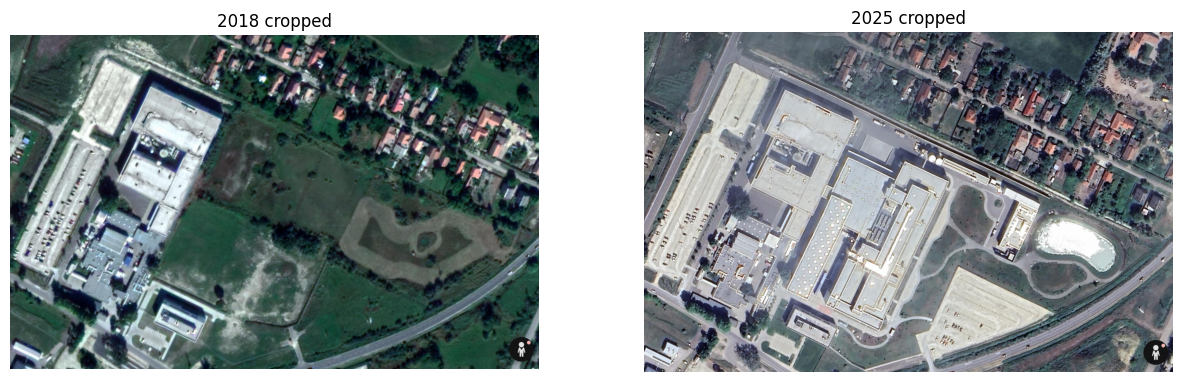

In [12]:
# Transpose to RGBimg2018_rgb = img2018_crop[:3].transpose(1, 2, 0)
img2018_rgb = img2018_crop[:3].transpose(1, 2, 0)
img2025_rgb = img2025_crop[:3].transpose(1, 2, 0)

img2018_rgb = img2018_rgb / img2018_rgb.max()
img2025_rgb = img2025_rgb / img2025_rgb.max()

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(img2018_rgb)
plt.title("2018 cropped")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2025_rgb)
plt.title("2025 cropped")
plt.axis('off')
plt.show()

In [13]:
geoai.get_raster_info(image_2025)

{'driver': 'GTiff',
 'width': 1874,
 'height': 1206,
 'count': 4,
 'dtype': 'uint8',
 'crs': 'EPSG:4326',
 'transform': Affine(3.8527214514408895e-06, 0.0, 19.80056,
        0.0, -2.5373134328340317e-06, 47.19139),
 'bounds': BoundingBox(left=19.80056, bottom=47.18833, right=19.80778, top=47.19139),
 'resolution': (3.8527214514408895e-06, 2.5373134328340317e-06),
 'nodata': None,
 'band_stats': [{'band': 1,
   'min': 0.0,
   'max': 255.0,
   'mean': 127.67616515430673,
   'std': 60.72350918563452},
  {'band': 2,
   'min': 0.0,
   'max': 255.0,
   'mean': 131.0360293870385,
   'std': 58.22607125238569},
  {'band': 3,
   'min': 0.0,
   'max': 255.0,
   'mean': 136.0282242292628,
   'std': 54.971575580087816},
  {'band': 4, 'min': 255.0, 'max': 255.0, 'mean': 255.0, 'std': 0.0}]}

In [14]:
# Check raster information
geoai.get_raster_info(image_2018)

{'driver': 'GTiff',
 'width': 1890,
 'height': 1196,
 'count': 4,
 'dtype': 'uint8',
 'crs': 'EPSG:4326',
 'transform': Affine(3.82010582010594e-06, 0.0, 19.80056,
        0.0, -2.558528428091841e-06, 47.19139),
 'bounds': BoundingBox(left=19.80056, bottom=47.18833, right=19.80778, top=47.19139),
 'resolution': (3.82010582010594e-06, 2.558528428091841e-06),
 'nodata': None,
 'band_stats': [{'band': 1,
   'min': 0.0,
   'max': 255.0,
   'mean': 75.45724726159509,
   'std': 59.72625354469253},
  {'band': 2,
   'min': 0.0,
   'max': 255.0,
   'mean': 93.8737599759339,
   'std': 56.14742196101524},
  {'band': 3,
   'min': 0.0,
   'max': 255.0,
   'mean': 91.90365902213728,
   'std': 57.472211554925074},
  {'band': 4, 'min': 255.0, 'max': 255.0, 'mean': 255.0, 'std': 0.0}]}

In [18]:
# View the images
geoai.view_raster(image_2018)

In [19]:
geoai.view_raster(image_2025)

### Initialize Change Detection

Create the change detection system with optimal parameters.

In [20]:
# Initialize change detection
detector = geoai.ChangeDetection(sam_model_type="vit_h")
# The setting sam_model_type="vit_h" means you are using the Segment Anything Model (SAM)
# with the ViT-H (Vision Transformer Huge) architecture.
# This is the largest and most capable model variant in the SAM family.

# Configure parameters (following the torchange example)
detector.set_hyperparameters(
    change_confidence_threshold=142,
    use_normalized_feature=True,
    bitemporal_match=True,)

detector.set_mask_generator_params(
    points_per_side=32,
    stability_score_thresh=0.95,)

print("Change detection system initialized!")

Change detection system initialized!


### Run Change Detection

Execute change detection with instance segmentation and confidence scoring.

In [21]:
# Run change detection
results = detector.detect_changes(
    image_2018,
    image_2025,
    output_path=f"{out_folder}/binary_mask.tif",
    export_probability=True,
    probability_output_path=f"{out_folder}/probability_mask.tif",
    export_instance_masks=True,
    instance_masks_output_path=f"{out_folder}/instance_masks.tif",
    return_detailed_results=True,
    return_results=False)

Saved instance segmentation mask with 119 instances to change_detection_results/instance_masks.tif
Saved instance scores mask with 119 instances to change_detection_results/instance_masks_scores.tif


In [22]:
print(f"Change detection completed!")
print(f"Total instances detected: {results['summary']['total_masks']}")
print(f"Image size: {results['summary']['original_shape']}")

Change detection completed!
Total instances detected: 119
Image size: (1196, 1890)


### Analyze Results

Display key statistics and quality metrics.

In [23]:
# Display statistics
if "statistics" in results and results["statistics"]:
    print("Quality Statistics:")
    for metric, stats in results["statistics"].items():
        print(f"  {metric}: mean={stats['mean']:.3f}, std={stats['std']:.3f}")

Quality Statistics:
  iou_predictions: mean=0.911, std=0.060
  stability_scores: mean=0.969, std=0.012
  change_confidence: mean=-0.646, std=0.124
  areas: mean=3138.916, std=9836.350


In [24]:
# Show top instances
if "masks" in results and len(results["masks"]) > 0:
    print("\nTop 5 detected instances:")
    for i, mask in enumerate(results["masks"][:5]):
        print(
            f"  {i+1}. Instance {mask['mask_id']}: "
            f"IoU={mask['iou_pred']:.3f}, "
            f"Stability={mask['stability_score']:.3f}, "
            f"Area={mask['area']} pixels")


Top 5 detected instances:
  1. Instance 1: IoU=1.002, Stability=0.987, Area=9459 pixels
  2. Instance 2: IoU=0.998, Stability=0.988, Area=8073 pixels
  3. Instance 3: IoU=0.996, Stability=0.988, Area=3035 pixels
  4. Instance 4: IoU=0.995, Stability=0.988, Area=3862 pixels
  5. Instance 0: IoU=1.003, Stability=0.976, Area=35668 pixels


### Visualizations

In [25]:
# Read 2018 image
with rasterio.open(image_2018) as src18:
    img2018 = src18.read([1, 2, 3]).transpose(1, 2, 0)
    img2018 = img2018 / img2018.max()

# Read 2025 image
with rasterio.open(image_2025) as src25:
    img2025 = src25.read([1, 2, 3]).transpose(1, 2, 0)
    img2025 = img2025 / img2025.max()

# Read probability mask
with rasterio.open(f"{out_folder}/probability_mask.tif") as pm:
    prob_mask = pm.read(1)
    prob_mask = (prob_mask - prob_mask.min()) / (prob_mask.max() - prob_mask.min() + 1e-6)

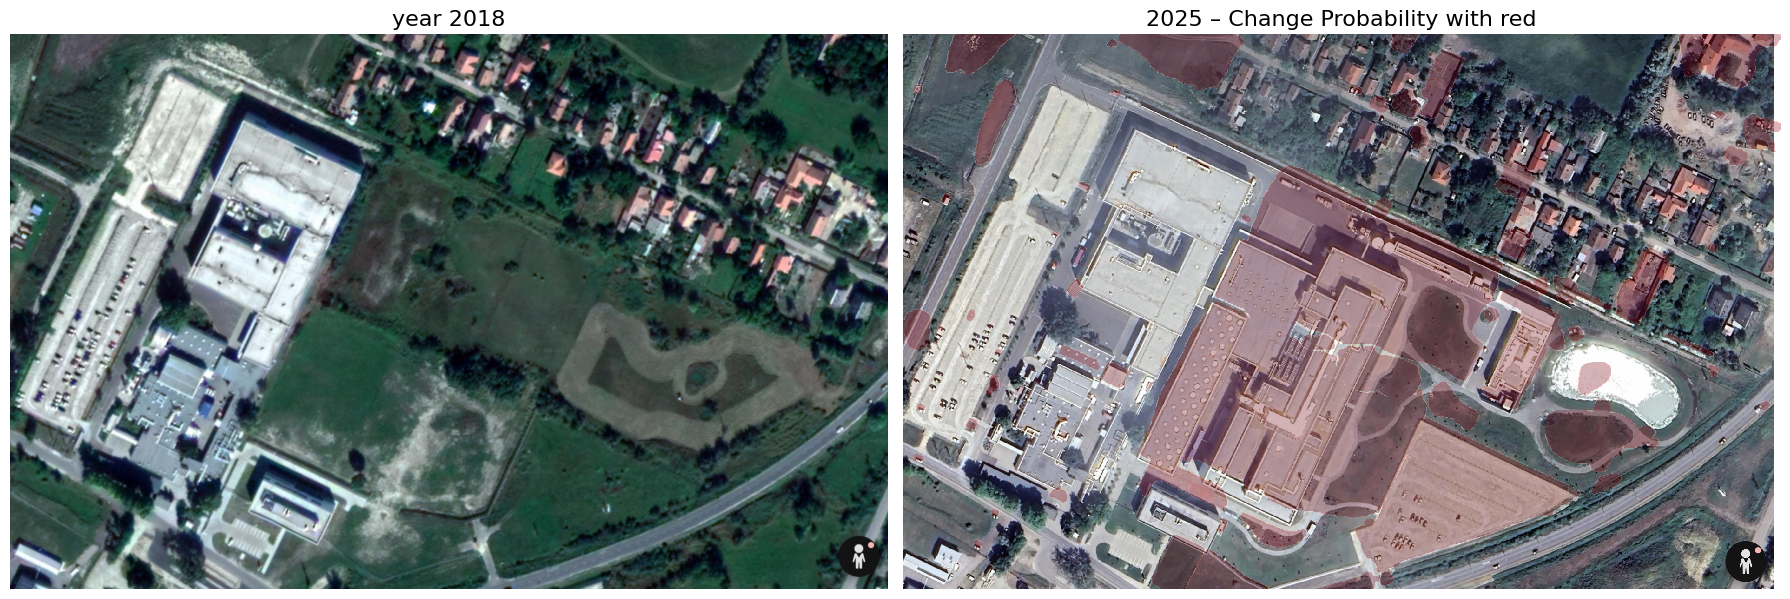

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(18, 9))

# Left side: 2018 image
axs[0].imshow(img2018)
# axs[0].imshow(prob_mask, alpha=0.3, cmap='Wistia')
axs[0].set_title("year 2018", fontsize=16)
axs[0].axis('off')

# Right side 2025 image + change probability
cmap = plt.cm.Reds.copy()
cmap.set_under((0, 0, 0, 0))
axs[1].imshow(img2025)
axs[1].imshow(prob_mask, alpha=0.3, cmap=cmap, vmin=1e-6)
axs[1].set_title("2025 – Change Probability with red", fontsize=16)
axs[1].axis('off')

plt.tight_layout()
plt.savefig(f"{out_folder}/result.png", dpi=300)
plt.show()

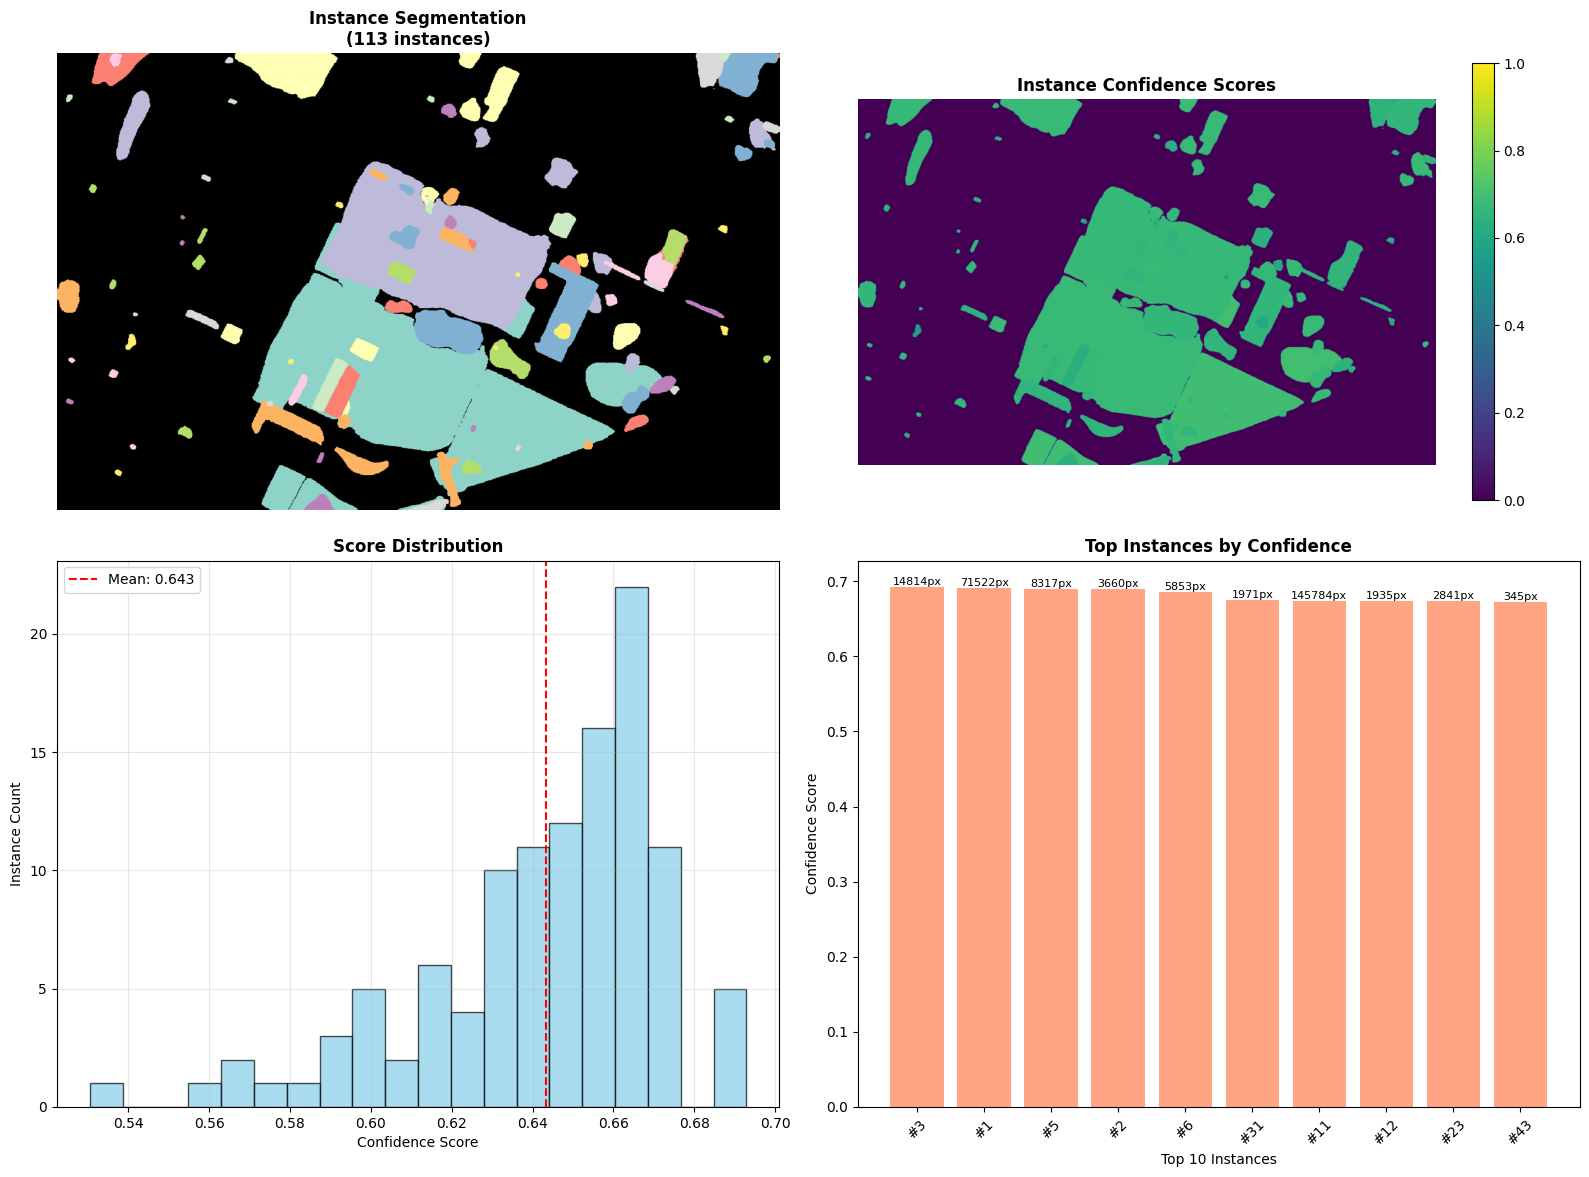


📊 Instance Analysis Summary:
   Total instances: 113
   Average confidence: 0.643
   Score range: 0.530 - 0.693
   Total change area: 257,042 pixels

💾 Instance analysis saved as 'change_detection_results/instance_analysis.png'


In [27]:
# Analyze individual instances
instance_stats = detector.analyze_instances(
    f"{out_folder}/instance_masks.tif",
    f"{out_folder}/instance_masks_scores.tif",
    f"{out_folder}/instance_analysis.png")

### Comprehensive Analysis Report

Generate a detailed analysis report combining all metrics.

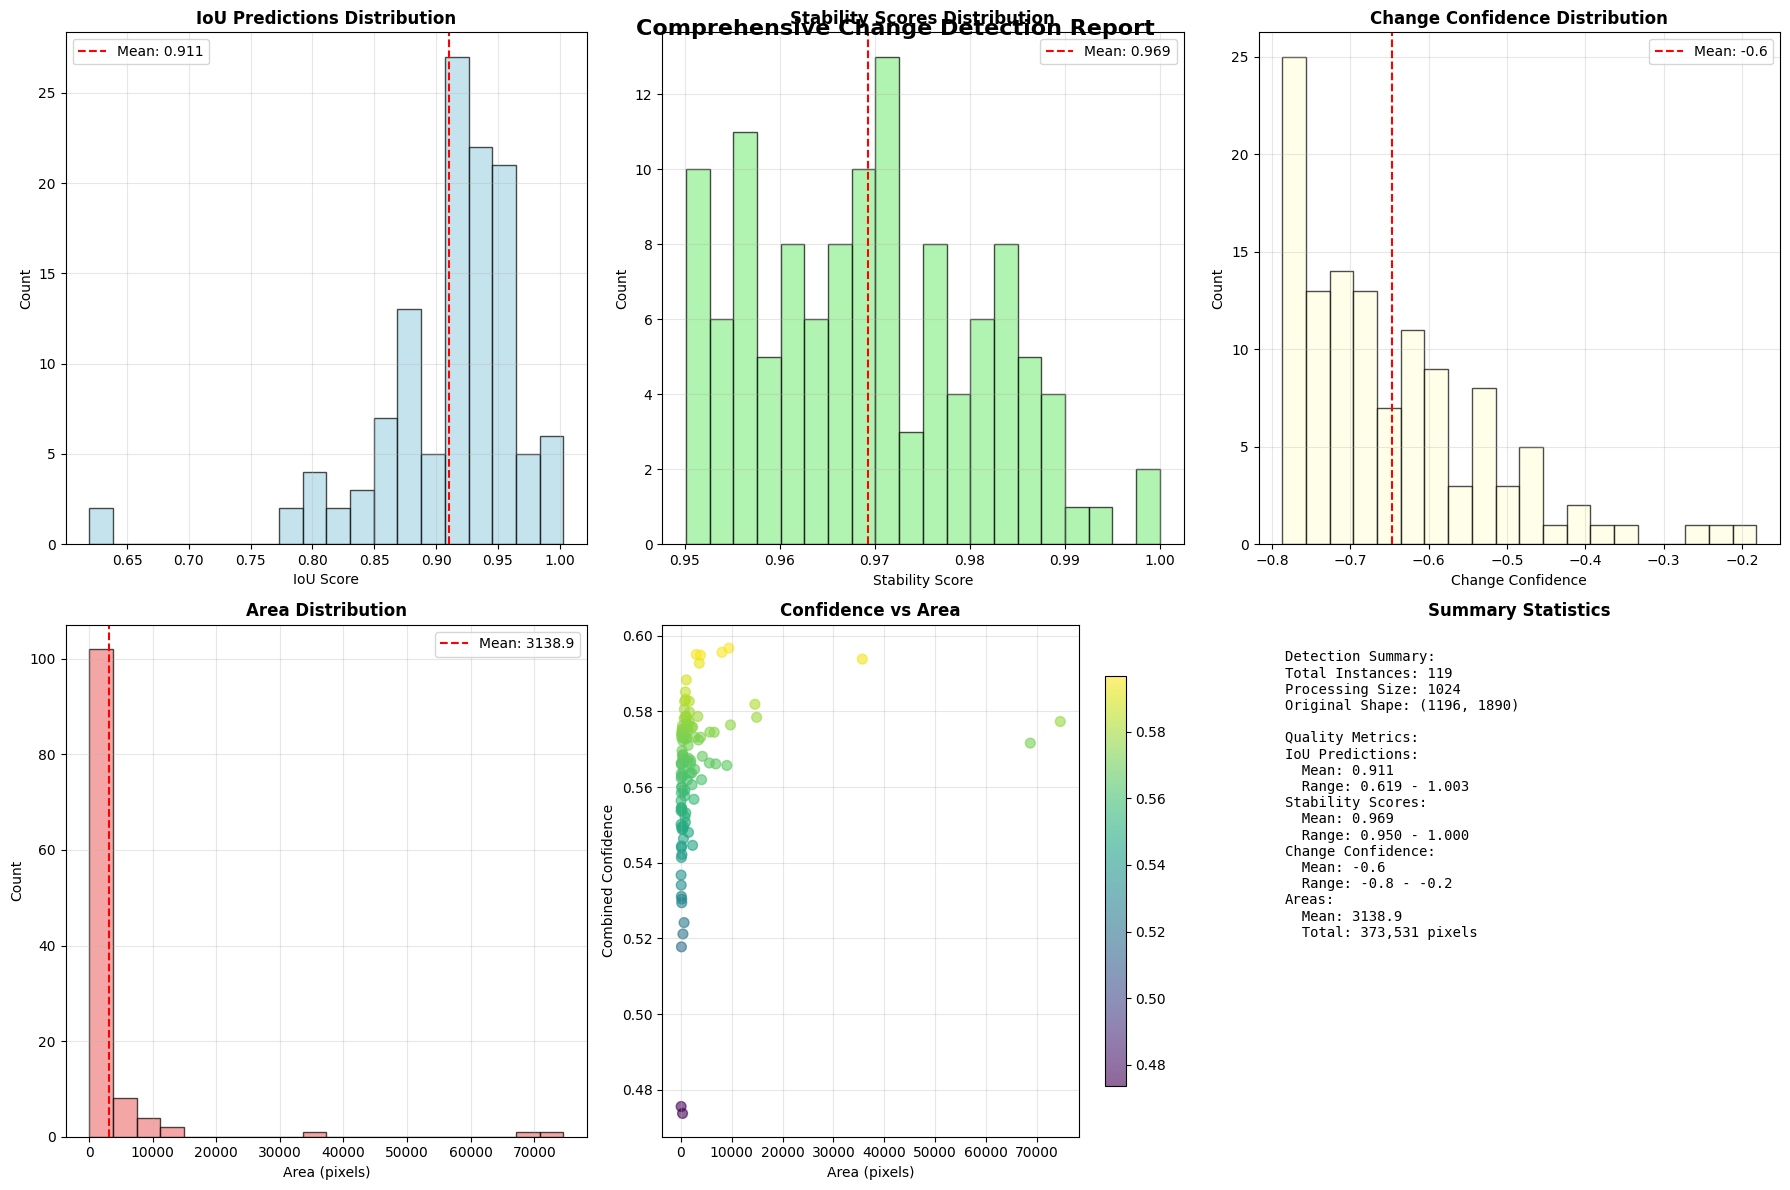

💾 Comprehensive report saved as 'change_detection_results/comprehensive_report.png'


In [28]:
# Create comprehensive analysis report
detector.create_comprehensive_report(results, f"{out_folder}/comprehensive_report.png")